# Install extra dependencies

In [1]:
!pip install -q torchinfo

/bin/bash: /home/mlewand/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# get filepaths

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torchinfo import summary
import os

USE_KAGGLE = False

if USE_KAGGLE:
    datapath = os.path.join("/kaggle", "input", "cityscapes-image-pairs", "cityscapes_data")
else:
    datapath = os.path.join("dataset", "cityscapes_data")

train_datapath = os.path.join(datapath, "train")
val_datapath = os.path.join(datapath, "val")

train_cs_datapath = os.path.join(datapath, "cityscapes_data", "train")
val_cs_datapath = os.path.join(datapath, "cityscapes_data", "val")

training_images_paths = [os.path.join(train_datapath, f) for f in os.listdir(train_datapath)]
validation_images_paths = [os.path.join(val_datapath, f) for f in os.listdir(val_datapath)]


print(f"size of training : {len(training_images_paths)}")
print(f"size of cityscapes training : {len(os.listdir(train_cs_datapath))}")
print(f"size of validation : {len(validation_images_paths)}")
print(f"size of cityscapes validation : {len(os.listdir(val_cs_datapath))}")

global_step = 0

size of training : 2975
size of cityscapes training : 2975
size of validation : 500
size of cityscapes validation : 500


# Data visualization

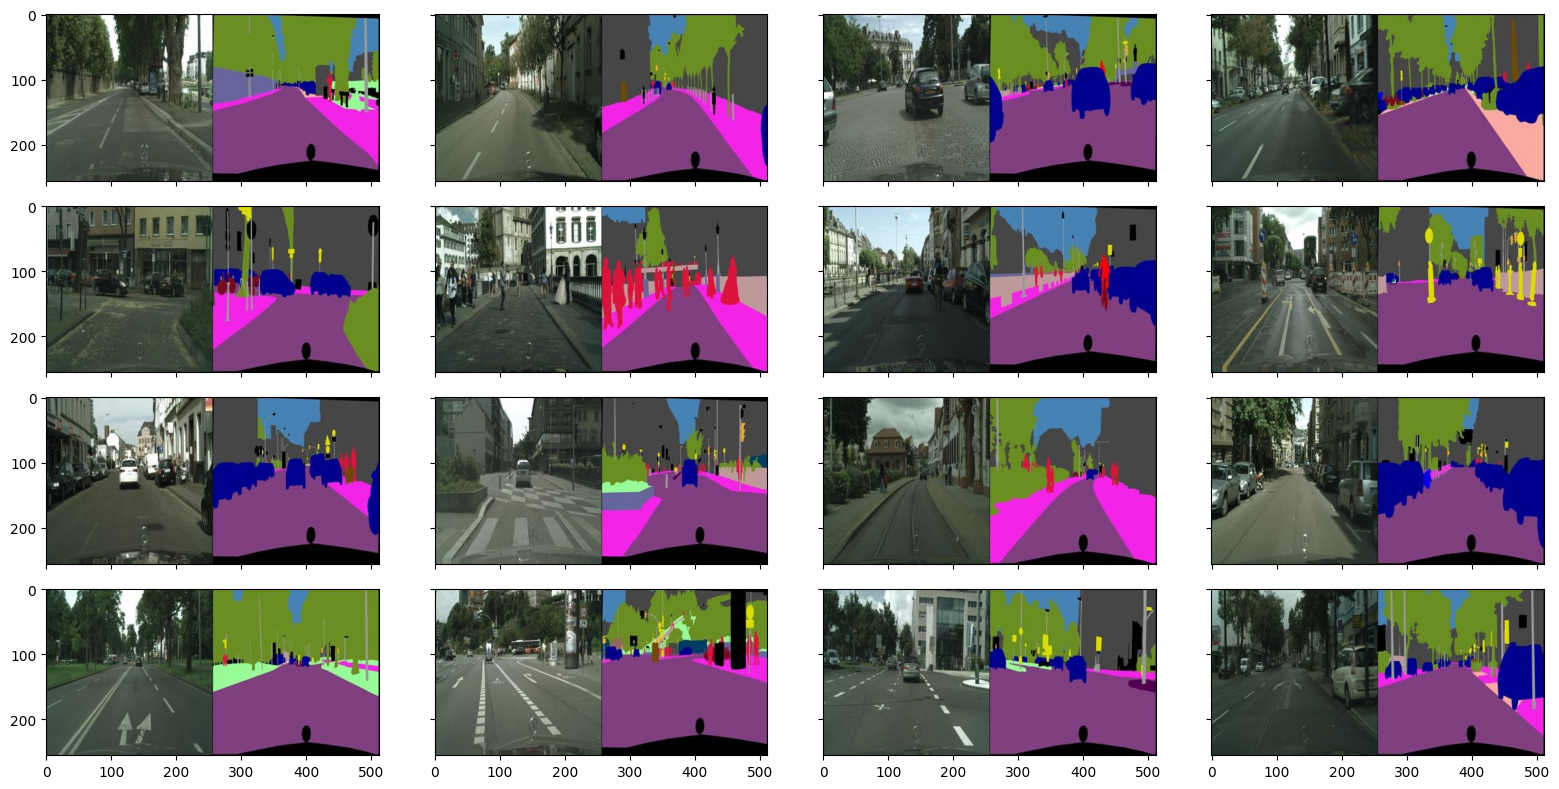

In [3]:
import torchvision
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

width = 4
height = 4
vis_batch_size = width * height

indexes = np.arange(len(training_images_paths))
indexes = np.random.permutation(indexes)[:vis_batch_size]
fig, axs = plt.subplots(height, width, sharex=True, sharey=True, figsize=(16, 8))

for i in range(vis_batch_size):
    img = torchvision.io.read_image(training_images_paths[indexes[i]])
    img = img.permute(1, 2, 0)
    
    # plt.subplot(height, width, i + 1)
    y, x = i // width, i % width
    
    axs[y, x].imshow(img.numpy())
    
plt.tight_layout()

# Data preprocessing

## labels 

In [4]:
from PIL import Image

# reference
# link : https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
idx_to_name = [ 'unlabeled','ego vehicle','rectification border', 'out of roi', 'static', 'dynamic','ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence','guard rail' , 'bridge','tunnel','pole', 'polegroup', 'traffic light', 'traffic sign' ,'vegetation', 'terrain', 'sky' ,'person', 'rider', 'car','truck' ,'bus', 'caravan','trailer', 'train' , 'motorcycle','bicycle','license plate']
idx_to_category = ["void", "flat", "construction", "object", "nature", "sky", "human", "vehicle"]

idx_to_color = [[ 0,  0,  0], [ 0,  0,  0], [  0,  0,  0], [  0,  0,  0],[ 0,  0,  0],[111, 74,  0],[81,  0, 81] ,[128, 64,128],[244, 35,232],
                [250,170,160],[230,150,140],[70, 70, 70],[102,102,156],[190,153,153],[180,165,180],[150,100,100],[150,120, 90],[153,153,153],
                [153,153,153],[250,170, 30],[220,220,  0],[107,142, 35],[152,251,152],[ 70,130,180],[220, 20, 60],[255,  0,  0],[ 0,  0,142],
                [ 0,  0, 70],[ 0, 60,100],[ 0,  0, 90],[  0,  0,110],[ 0, 80,100],[  0,  0,230],[119, 11, 32],[  0,  0,142]]


idx_to_color_np = np.array(idx_to_color)

name_to_category = {0 : 0, 1 : 0, 2 : 0, 3: 0, 4 : 0, 5 : 0, 6 : 0, 7 : 1, 8 : 1, 9 : 1, 10 : 1, 11 :2, 12 : 2, 13 : 2, 14 : 2, 15 : 2, 16 : 2,
                    17 : 3, 18 : 3, 19 : 3, 20: 3, 21 : 4, 22 : 4, 23 : 5, 24 : 6, 25 : 6, 26 : 7, 27 : 7, 28 : 7, 29 : 7, 30 : 7, 31 : 7, 32: 7, 33 : 7, 34 : 7}

## Image processing

size of input :  (128, 128, 3)
size of mask raw :  (128, 128, 3)
size of classes :  (128, 128)


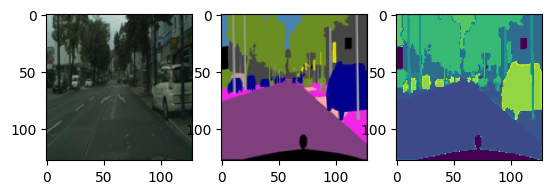

In [5]:
name_to_category_mapping = lambda x: name_to_category[x]
vectorized_cat_mapping = np.vectorize(name_to_category_mapping)

name_to_col_mapping = lambda x: idx_to_color[x]
vectorized_col_mapping = np.vectorize(name_to_col_mapping)

def preprocess_image(path, sparse_mapping=True, downscale_factor=None):
    # read the numpy data from jpeg image
    img = Image.open(path)
    
    width, height = img.size

    if downscale_factor:
        width, height = width // downscale_factor, height//downscale_factor 
        img = img.resize(( width, height ))

    img = np.asarray(img)
    
    raw, mask = img[:, :width//2, :], img[:, width//2:, :]
    
    height, width, channels = mask.shape
    
    distances = np.sum((mask.reshape(-1, channels)[:, np.newaxis, :] - idx_to_color_np)**2, axis=2)
    classes = np.argmin(distances, axis=1).reshape(height, width)
    
    if sparse_mapping:
        classes = vectorized_cat_mapping(classes)
    
    return raw, mask, classes

#                                                                                                necessary for kaggle
#                                                                                                otherwise images 256x256 are very slow
#                                                                                                and will crash due to RAM requirements
x, mask_raw, classes = preprocess_image(training_images_paths[indexes[i]], sparse_mapping=False, downscale_factor=2)

print("size of input : ", x.shape)
print("size of mask raw : ", mask_raw.shape)
print("size of classes : ", classes.shape)
plt.subplot(1, 3, 1)
plt.imshow(x)
plt.subplot(1, 3, 2)
plt.imshow(mask_raw)
plt.subplot(1, 3, 3)
plt.imshow(classes)
plt.show()

# Load data and Pytorch dataset

## Load dataset

In [7]:
from tqdm.auto import tqdm

train_images_to_use = 100

# for kaggle
downscale_factor=None

X_train, Y_train = [], []
X_val, Y_val = [], []

for path in tqdm(training_images_paths[:train_images_to_use]):
    X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
    X_train.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_train.append(torch.Tensor(Y))

for path in tqdm(validation_images_paths):
    X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
    X_val.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_val.append(torch.Tensor(Y))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

## Pytorch Dataset

In [8]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CityScapesDataset(Dataset):
    def __init__(self, X, Y, transform=None, target_transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]

        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x , y

train_ds = CityScapesDataset(X_train, Y_train)
val_ds = CityScapesDataset(X_val, Y_val)

train_dataloader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=8, shuffle=True)

## Test dataset

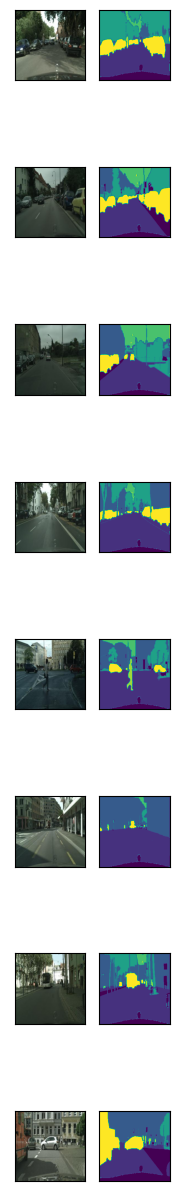

In [9]:
batch_size = 8

plt.figure(figsize=(2, 2 * batch_size))
for i in range(8):
    img, mask = X_train[i], Y_train[i]  
    #print(img.shape, mask.shape)
    plt.subplot(batch_size, 2, 2 * i + 1)
    plt.imshow(img.permute(1,2, 0))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(batch_size, 2, 2 * i + 2)
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    

torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])


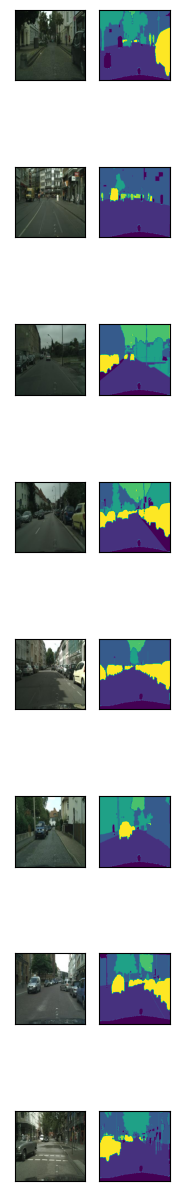

In [10]:
batch = next(iter(train_dataloader))

print(batch[0].shape, batch[1].shape)
batch_size = batch[0].shape[0]

plt.figure(figsize=(2, 2 * batch_size))
for i in range(batch_size):
    img, mask = batch[0][i], batch[1][i]  
    #print(img.shape, mask.shape)
    plt.subplot(batch_size, 2, 2 * i + 1)
    plt.imshow(img.permute(1,2, 0))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(batch_size, 2, 2 * i + 2)
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    

# UNET (pytorch model)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F 

class DoubleConv(nn.Module):
    """ Conv2d -> BatchNorm2d - Relu -> Conv2d -> BatchNorm2d -> Relu """
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
            
        self.double_conv = nn.Sequential(nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
                                         nn.BatchNorm2d(mid_channels),
                                         nn.ReLU(inplace=True),
                                         nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
                                         nn.BatchNorm2d(out_channels),
                                         nn.ReLU(inplace=True))
    
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2),
                                          DoubleConv(in_channels, out_channels))
    
    def forward(self, x):
        return self.maxpool_conv(x)
    

class Up(nn.Module):
    """Upscaling then double conv"""
    
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is (batch, channel, height, width)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        return self.conv(x)
    

class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, start=32, bilinear=False):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, start)
        self.down1 = Down(start, 2*start)
        self.down2 = Down(2*start, 4*start)
        self.down3 = Down(4*start, 8*start)
        
        factor = 2 if bilinear else 1
        self.down4 = Down(8*start, 16*start // factor)
        
        self.up1 = Up(16*start, 8*start // factor, bilinear)
        self.up2 = Up(8*start, 4*start // factor, bilinear)
        self.up3 = Up(4*start, 2*start // factor, bilinear)
        self.up4 = Up(2*start, start, bilinear)
        self.outc = OutConv(start, n_classes)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
    

number_of_classes = len(set(name_to_category.values()))
summary(Unet(3, number_of_classes), input_data=batch[0])

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [8, 8, 256, 256]          --
├─DoubleConv: 1-1                             [8, 32, 256, 256]         --
│    └─Sequential: 2-1                        [8, 32, 256, 256]         --
│    │    └─Conv2d: 3-1                       [8, 32, 256, 256]         864
│    │    └─BatchNorm2d: 3-2                  [8, 32, 256, 256]         64
│    │    └─ReLU: 3-3                         [8, 32, 256, 256]         --
│    │    └─Conv2d: 3-4                       [8, 32, 256, 256]         9,216
│    │    └─BatchNorm2d: 3-5                  [8, 32, 256, 256]         64
│    │    └─ReLU: 3-6                         [8, 32, 256, 256]         --
├─Down: 1-2                                   [8, 64, 128, 128]         --
│    └─Sequential: 2-2                        [8, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-7                    [8, 32, 128, 128]         --
│    │    └─Doub

# Pytorch util training

## Extra Losses

In [12]:
# dice loss : https://github.com/milesial/Pytorch-UNet/blob/master/utils/dice_score.py

from torch import Tensor

def dice_coeff(inp : Tensor, tgt : Tensor, eps=1e-6):
    sum_dim = (-1, -2, -3)
    
    inter = 2 *(inp * tgt).sum(dim=sum_dim)
    sets_sum = inp.sum(dim=sum_dim) + tgt.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)
    
    dice = (inter + eps) / (sets_sum + eps)
    return dice.mean()

def multiclass_dice_coeff(input: Tensor, target: Tensor, eps: float = 1e-6):
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), eps)

def dice_loss(input: Tensor, target: Tensor):
    # Dice loss (objective to minimize) between 0 and 1
    return 1 - multiclass_dice_coeff(input, target)

def IoU_coeff(inp : Tensor, tgt : Tensor, eps = 1e-6):
    sum_dim = (-1, -2, -3)
    
    # Intersection term  |A ^ B|
    inter = (inp * tgt).sum(dim=sum_dim)
    
    # sum of |A| + |B|
    sets_sum = inp.sum(dim=sum_dim) + tgt.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)
    
    # IoU = |A ^ B| / |A \/ B| = |A ^ B| / (|A| + |B| - |A^B|)
    
    return (inter + eps) / (sets_sum - inter + eps)

def IoU_loss(inp : Tensor, tgt : Tensor):
    return 1 - IoU_coeff(inp.flatten(0,1), tgt.flatten(0,1))

## Training / Eval code

In [13]:
import torch.optim as optim

epoch_to_fig = []

def evaluate_model(model, val_dataloader, epoch, epochs, criterion,
                   with_dice_loss=True, with_IoU_loss=False, save_figs=True):
    global epoch_to_fig 
    val_loss = 0
    training_dice = 0
    training_IoU = 0
    with tqdm(val_dataloader, desc=f"Epoch {epoch}/{epochs} ; val Loss 0") as pbar:
        model.eval()
        examples_so_far = 0
        for i, batch in enumerate(val_dataloader):
            images, true_masks = batch[0], batch[1]
                
            images = images.to(device)
            true_masks = true_masks.to(device).long()                
                
            # predictions
            masks_pred = model(images)
            
            loss = criterion(masks_pred, true_masks)
            val_loss += loss.item() * images.shape[0]
            examples_so_far += images.shape[0]

            dice = dice_loss(F.softmax(masks_pred, dim=1).float(),
                             F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
            
            if with_dice_loss:
                loss += dice
            training_dice += images.shape[0] * (1.-dice.item())
                
            IoU = IoU_loss(F.softmax(masks_pred, dim=1).float(),
                           F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
            
            if with_IoU_loss:
                loss += IoU
            training_IoU += images.shape[0] * (1.-IoU.item())
            
            pbar.update(1)
                
            descr = f"Epoch {epoch}/{epochs} ; val Loss {round(val_loss / examples_so_far ,3)}, val IoU : {round(training_IoU / examples_so_far ,3)}, val Dice : {round(training_dice / examples_so_far ,3)}"               
            pbar.set_description(descr)
    
    if save_figs:
        val_batch = next(iter(val_dataloader))
        images = val_batch[0].to(device)

        true_classes = val_batch[1]
        true_classes = torch.stack([true_classes, true_classes, true_classes]).permute(1, 2, 3, 0) / (number_of_classes-1)

        preds = model(images)
        pred_classes = torch.argmax(preds.permute(0,2,3,1), dim=3)
        pred_classes = torch.stack([pred_classes, pred_classes, pred_classes]).permute(1, 2, 3, 0) / (number_of_classes-1)

        scale = 5
        batch_size = pred_classes.shape[0]

        images = images.permute(0,2,3,1)
        pred_true = torch.cat([images.to("cpu"), pred_classes.to("cpu"), true_classes.to("cpu")], dim=2)


        to_vis = pred_true.reshape(-1, pred_true.shape[2], pred_true.shape[3])
        epoch_to_fig.append(to_vis)

def train_model(model, device, train_dataloader,
                val_dataloader, epochs=10, lr=1e-4, update_pb_every_batch = 1,
                with_dice_loss=True, with_IoU_loss=False):
    global global_step
    
    # setup the optimizer, loss, learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(1, epochs + 1):
        
        training_loss = 0
        training_dice = 0
        training_IoU = 0
        with tqdm(train_dataloader, desc=f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss,3)}") as pbar:
            model.train()
            optimizer.zero_grad()
            examples_so_far = 0
            for i,batch in enumerate(train_dataloader):
                images, true_masks = batch[0], batch[1]
                
                images = images.to(device)
                true_masks = true_masks.to(device).long()
                                
                masks_pred = model(images)
                
                loss = criterion(masks_pred, true_masks)
                if with_dice_loss:
                    dice = dice_loss(F.softmax(masks_pred, dim=1).float(),
                              F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
                    loss += dice
                    training_dice += images.shape[0] * (1.-dice.item())
                
                if with_IoU_loss:
                    IoU = IoU_loss(F.softmax(masks_pred, dim=1).float(),
                              F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
                    loss += IoU
                    training_IoU += images.shape[0] * (1.-IoU.item())
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                global_step += 1
                training_loss += images.shape[0] * loss.item()
                examples_so_far += images.shape[0]

                pbar.update(1)
                if i % update_pb_every_batch == 0:
                    descr = f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss / examples_so_far ,3)}"        
                    if with_dice_loss:
                        descr = f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss / examples_so_far ,3)}, avg DICE : {round(training_dice / examples_so_far ,3)}"   
                    elif with_IoU_loss:
                        descr = f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss / examples_so_far ,3)}, avg IoU : {round(training_IoU / examples_so_far ,3)}"
                    
                    pbar.set_description(descr)
        
        evaluate_model(model, val_dataloader, epoch, epochs, criterion, with_dice_loss=with_dice_loss, with_IoU_loss=with_IoU_loss)

In [14]:
device = "cuda"
model = Unet(3, number_of_classes)
model = model.to(device)

train_model(model, device, train_dataloader, val_dataloader, update_pb_every_batch=10)

Epoch 1/10 ; training Loss 0:   0%|          | 0/13 [00:00<?, ?it/s]

: 

: 